# Build the Gaia DR2 'Gold' 6D sample

Build a clean 6D (astrometry plus radial velocity) sample from the Gaia DR2 data. The starting point is a sample filtered according to:

* Radial velocity must exist in Gaia DR2
* The source must have a 5-parameters astrometric solution
* Relative parallax error is better than 20\%: $\varpi/\sigma_\varpi>5$

The corresponding ADQL query:

```
select *
from gaiadr2.gaia_source
where parallax_over_error>5
and radial_velocity is not null
and astrometric_params_solved=31
```

This query results in 6376803 sources for a file (FITS decompressed) of about 4.2 GB. All Gaia DR2 fields are returned and this are not really needed for a "gold" sample. To keep the size of the file more manageable one can apply some quality cuts directly in the query and restrict which columns are downloaded. The following examples show how to select stars with 6D phase space information, for studies of 3D positions and kinematics and for studies of the CMD (in combination with the phase space information).

### Sample for precise kinematics (6D phase space)

To clean up the sample from stars with potentially problematic radial velocities on can follow the recommendations  from [Boubert et al. (2019)](https://arxiv.org/abs/1901.10460)
:
* More that three RVS observations of the source: `rv_nb_transits > 3`
* Exclude the list of sources with bright neighbours within $6.4$ arcseconds. Use [this list](https://arxiv.org/src/1901.10460v1/anc/rvscontamination.csv). This step is done after the query.

Query:

```
select source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, parallax_over_error, pmra,
pmra_error, pmdec, pmdec_error, ra_dec_corr, ra_parallax_corr, ra_pmra_corr, ra_pmdec_corr,
dec_parallax_corr, dec_pmra_corr, dec_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr, 
pmra_pmdec_corr, radial_velocity, radial_velocity_error,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, g_rp, bp_g, 
2.5/log(10)*phot_g_mean_flux_over_error as phot_g_mean_mag_error,
2.5/log(10)*phot_bp_mean_flux_over_error as phot_bp_mean_mag_error,
2.5/log(10)*phot_rp_mean_flux_over_error as phot_rp_mean_mag_error,
sqrt(astrometric_chi2_al/(astrometric_n_good_obs_al-5)) as uwe
from gaiadr2.gaia_source
where parallax_over_error>5
and radial_velocity is not null
and astrometric_params_solved=31
and rv_nb_transits > 3
```

This retrieves all the fields needed to calculate the 6D phase space coordinates and their uncertainties (full covariance matrix) and also downloads the photometric information. Note that the errors on the magnitudes are calculated as part of the query (e.g. `2.5/log(10)*phot_bp_mean_flux_over_error as phot_bp_mean_mag_error`). In addition the so-called Unit Weight Error (UWE, reduced $\chi^2$) is calculated as part of the query and returned in the field `uwe`: `sqrt(astrometric_chi2_al/(astrometric_n_good_obs_al-5)) as uwe`

This query results in 5573496 sources and a decompressed FITS file size of 1.1 GB

### Sample for high-quality CMD and 6D phase space

For a high-precision CMD for which 6D phase data is available one can further filter the sample as in [Gaia Collaboration, Babusiaux et al. (2018)](https://doi.org/10.1051/0004-6361/201832843):

High signal-to-noise photometry

* `phot_g_mean_flux_over_error>50`
* `phot_bp_mean_flux_over_error>20`
* `phot_rp_mean_flux_over_error>20`

Further cleaning of the photometry according to the flux excess factor

* `1.0+0.015*(bp_rp*bp_rp)<phot_bp_rp_excess_factor`
* `1.3+0.06*(bp_rp*bp_rp)>phot_bp_rp_excess_factor`

Query:

```
select source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, parallax_over_error, pmra,
pmra_error, pmdec, pmdec_error, ra_dec_corr, ra_parallax_corr, ra_pmra_corr, ra_pmdec_corr,
dec_parallax_corr, dec_pmra_corr, dec_pmdec_corr, parallax_pmra_corr, parallax_pmdec_corr, 
pmra_pmdec_corr, radial_velocity, radial_velocity_error, 
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, bp_rp, g_rp, bp_g, 
2.5/log(10)*phot_g_mean_flux_over_error as phot_g_mean_mag_error,
2.5/log(10)*phot_bp_mean_flux_over_error as phot_bp_mean_mag_error,
2.5/log(10)*phot_rp_mean_flux_over_error as phot_rp_mean_mag_error,
sqrt(astrometric_chi2_al/(astrometric_n_good_obs_al-5)) as uwe
from gaiadr2.gaia_source
where parallax_over_error>5
and radial_velocity is not null
and astrometric_params_solved=31
and rv_nb_transits > 3
and phot_g_mean_flux_over_error>50
and phot_bp_mean_flux_over_error>20
and phot_rp_mean_flux_over_error>20
and 1.0+0.015*(bp_rp*bp_rp)<phot_bp_rp_excess_factor
and 1.3+0.06*(bp_rp*bp_rp)>phot_bp_rp_excess_factor
```

This query results in 5547478 sources with a decompressed FITS file size of 1.1 GB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from astropy.table import Table
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential, Galactic
import astropy.units as u

from ruwetools import U0Interpolator
from plotstyles import useagab, apply_tufte

## Load the data, carry out filtering

After the data has been downloaded some further cleaning steps should be taken. The first is to filter out sources with potentially spurious parallaxes or proper motions, using the so-called Renormalized Unit Weight Error (RUWE). This is explained in detail in [these slides](https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf/1ebddb25-f010-6437-cb14-0e360e2d9f09) and this [technical note](http://www.rssd.esa.int/doc_fetch.php?id=3757412). The second step corrects the Gaia DR2 photometry for slight systematic trends of the values of $G$, $G_\mathrm{BP}$ and $G_\mathrm{RP}$ with $G$ or $G_\mathrm{RP}$. This is explained on the Gaia DR2 Known Issues [page](https://www.cosmos.esa.int/web/gaia/dr2-known-issues#PhotometrySystematicEffectsAndResponseCurves).

### The renormalized unit weight error

The unit weight error is given by:

\begin{equation}
    \text{UWE} = \left(\frac{\text{astrometric_chi2_al}}{\text{astrometric_n_good_obs_al}-5)}\right)^{1/2}\,.
\end{equation}

In the second and third query above the value of UWE is already calculated as part of the ADQL query. This value is then renormalized by dividing by the typical value for the UWE, $u_0$, as a function of colour and magnitude.

\begin{equation}
    \text{RUWE} = \frac{\text{UWE}}{u_0(G, G_\mathrm{BP}-G_\mathrm{RP})}\,.
\end{equation}

### Photometry corrections

The following corrections are made to the photometry in $G$, $G_\mathrm{BP}$ and $G_\mathrm{RP}$ as suggested on the Gaia DR2 Known Issues [page](https://www.cosmos.esa.int/web/gaia/dr2-known-issues#PhotometrySystematicEffectsAndResponseCurves):

*  $2\le G\leq6$: compute corrected magnitudes as $G_\mathrm{corr} = -0.047344 + 1.16405 G - 0.046799 G^2 + 0.0035015G^3$ (following the saturation correction detailed in [Evans et al. 2018](https://www.aanda.org/articles/aa/abs/2018/08/aa32756-18/aa32756-18.html), Appendix B)
* $6< G\leq16$: compute corrected magnitudes as $G_\mathrm{corr} = G-0.0032(G-6)$ (following [Maíz Apellániz & Weiler](https://www.aanda.org/articles/aa/abs/2018/11/aa34051-18/aa34051-18.html) 2018)
* $G>16$: compute corrected magnitudes as $G_\mathrm{corr} = G-0.032$
* $2<G<4$: compute corrected $G_\mathrm{BP}$ magnitudes as: $G_\mathrm{BP}-2.0384+0.95282 G-0.11018 G^2$
* $2<G<3.5$: compute corrected $G_\mathrm{RP}$ magnitudes as: $-13.946+14.239G_\mathrm{RP}-4.23G_\mathrm{RP}^2+0.4532G_\mathrm{RP}^3$

### Removal of potentially spurious RVS values caused by bright neighbours

This step goes through the list from [Boubert et al. (2019)](https://arxiv.org/abs/1901.10460) and removes the sources in that list from the sample.

In [2]:
boubertlist = Table.read("./data/rvscontamination.csv", format="csv")

## Example 1: the CMD for stars with 6D information

Next the data is loaded for the sample selected for making a clean CMD for stars with clean 6D phase space information. The effect of further filtering on the value of RUWE is shown.

In [3]:
cmddata = Table.read("./data/GaiaDR2-6DGoldCMD-StartingSample.fits", format='fits')
sample_size = cmddata['source_id'].size
print("Number of sources in input table: {0}".format(sample_size))

# Next line only needed in case you downloaded astrometric_chi2_al and astrometric_n_good_obs_al instead 
# of calculting the UWE in the ADQL query.
#cmddata['uwe'] = np.sqrt(cmddata['astrometric_chi2_al']/(cmddata['astrometric_n_good_obs_al']-5))

rwi = U0Interpolator()
if (cmddata['phot_g_mean_mag'].size!=sample_size or cmddata['bp_rp'].size!=sample_size):
    print("WARNING: table contains entries without G or (BP-RP).")
cmddata['ruwe'] = cmddata['uwe']/rwi.get_u0(cmddata['phot_g_mean_mag'], cmddata['bp_rp'])

Gdr2 = cmddata['phot_g_mean_mag']
GBPdr2 = cmddata['phot_bp_mean_mag']
GRPdr2 = cmddata['phot_rp_mean_mag']

conditionsG = [(Gdr2 > 6.0) & (Gdr2 <=16), (Gdr2 > 16), (Gdr2 <= 6.0)]
optionsG = [Gdr2 - 0.0032*(Gdr2-6), Gdr2 - 0.032, 
            -0.047344 + 1.16405*Gdr2 -0.046799*Gdr2**2 + 0.0035015*Gdr2**3]
cmddata['phot_g_mean_mag_corr'] = np.select(conditionsG, optionsG)

cmddata['phot_bp_mean_mag_corr'] = np.where((Gdr2> 2) & (Gdr2< 4), 
                                            GBPdr2-2.0384+0.95282*Gdr2-0.11018*Gdr2**2, GBPdr2)
cmddata['phot_rp_mean_mag_corr'] = np.where((Gdr2> 2) & (Gdr2< 3.5), 
                                            -13.946+14.239*GRPdr2-4.23*GRPdr2**2+0.4532*GRPdr2**3, GRPdr2)
cmddata['bp_rp_corr'] = cmddata['phot_bp_mean_mag_corr'] - cmddata['phot_rp_mean_mag_corr']
cmddata['g_rp_corr'] = cmddata['phot_g_mean_mag_corr'] - cmddata['phot_rp_mean_mag_corr']
cmddata['bp_g_corr'] = cmddata['phot_bp_mean_mag_corr'] - cmddata['phot_g_mean_mag_corr']

Number of sources in input table: 5547478


### Examine UWE and RUWE histograms

The histograms below show the distribution of UWE and RUWE and illustrate how the RUWE histogram is much closer to the expected distribution of a reduced $\chi^2$. One should normally experiment to find the appropriate upper limit on the value of the RUWE for a given sample. Below we stick to the value used in the [explanatory slides](https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf/1ebddb25-f010-6437-cb14-0e360e2d9f09).

Number of sources with RUWE<1.4: 5216731, 94.04%
Number of sources with UWE<1.96: 5182046, 93.41%


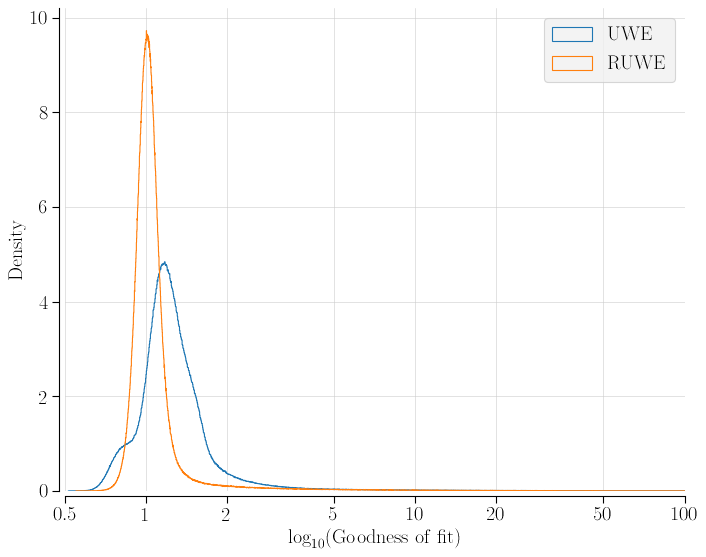

In [4]:
ruwe_limit = 1.4
uwe_limit = 1.96

n_ruwe_low = cmddata['ruwe'][cmddata['ruwe']<ruwe_limit].size
n_uwe_low = cmddata['uwe'][cmddata['uwe']<uwe_limit].size

print("Number of sources with RUWE<1.4: {0}, {1:.2f}%".format(n_ruwe_low, 100*n_ruwe_low/sample_size))
print("Number of sources with UWE<1.96: {0}, {1:.2f}%".format(n_uwe_low, 100*n_uwe_low/sample_size))

useagab(usetex=False, fontfam='sans', sroncolours=False)

figb, axb = plt.subplots(1, 1, figsize=(10,8))
apply_tufte(axb, withgrid=True)

axb.hist(np.log10(cmddata['uwe']), bins='auto', histtype='step', density=True, label='UWE')
axb.hist(np.log10(cmddata['ruwe']), bins='auto', histtype='step', density=True, label='RUWE')
axb.legend(loc='best')
axb.set_xticks(np.log10([0.5,1,2,5,10,20,50,100]), minor=False)
axb.set_xticklabels(['0.5','1','2','5','10','20','50','100'], minor=False)
axb.set_xlabel('$\log_{10}(\mathrm{Goodness\ of\ fit})$')
axb.set_ylabel('Density')
axb.set_xlim(np.log10(0.5),np.log10(100))

plt.show()

### CMD filtered according to RUWE and with sources with potentially spurious RVs removed

Below an example is shown of the effect of filtering on RUWE on the CMD. Filtering is by $\text{RUWE}<1.4$ as used in the [explanatory slides](https://www.cosmos.esa.int/documents/29201/1770596/Lindegren_GaiaDR2_Astrometry_extended.pdf/1ebddb25-f010-6437-cb14-0e360e2d9f09).

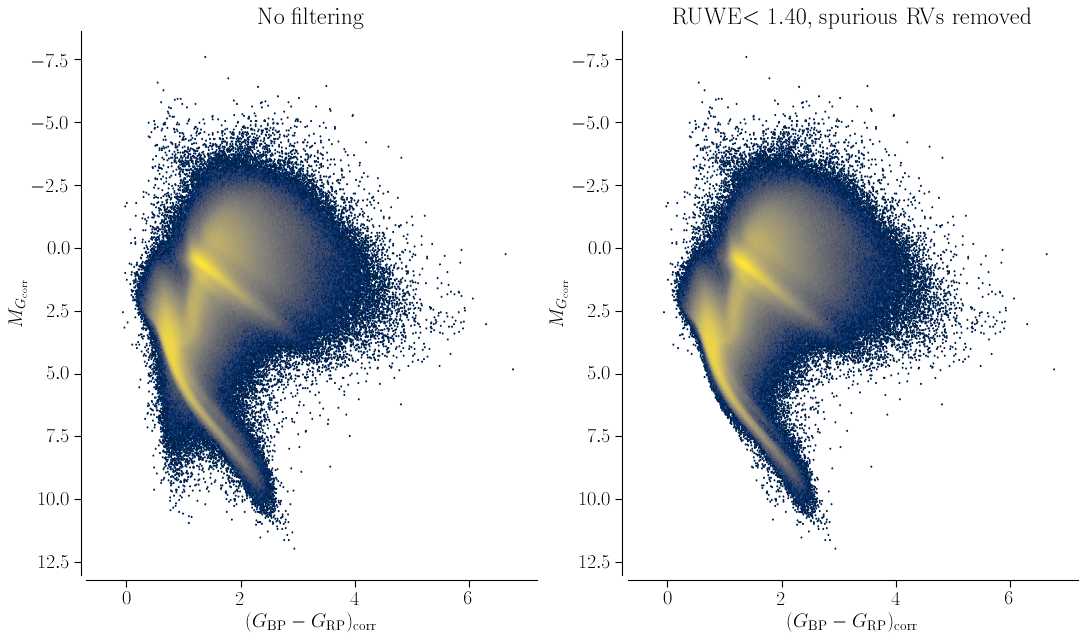

In [5]:
lowruwecmd = cmddata['ruwe']<1.40
reliable_vradcmd = ~np.isin(cmddata['source_id'],boubertlist['source_id'])

cleancmd = lowruwecmd & reliable_vradcmd

gabs = cmddata['phot_g_mean_mag_corr']+5*np.log10(cmddata['parallax'])-10

useagab(usetex=False, fontfam='sans', sroncolours=False)
fig, (axa, axb) = plt.subplots(1, 2, figsize=(16,9))
apply_tufte(axa)
apply_tufte(axb)

axa.hexbin(cmddata['bp_rp_corr'], gabs, mincnt=1, bins='log', gridsize=500, cmap='cividis')
axa.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_\mathrm{corr}$')
axa.set_ylabel(r'$M_{G_\mathrm{corr}}$')
axa.set_xlim(-0.7,7.2)
axa.set_ylim(-8.6,13)
axa.invert_yaxis()
axa.set_title('No filtering')

axb.hexbin(cmddata['bp_rp_corr'][cleancmd], gabs[cleancmd], mincnt=1, bins='log', 
           gridsize=500, cmap='cividis')
axb.set_xlabel(r'$(G_\mathrm{BP}-G_\mathrm{RP})_\mathrm{corr}$')
axb.set_ylabel(r'$M_{G_\mathrm{corr}}$')
axb.set_xlim(axa.get_xlim())
axb.set_ylim(axa.get_ylim())
axb.set_title('RUWE$<1.40$, spurious RVs removed')

#plt.savefig('ruwe_filter_example.png')
plt.show()

## Example 2: 3D positions and motions

Next we calculate the phase space coordinates of the stars in the Galactocentric cylindrical coordinate system. This involves a specific choice for some Milky Way parameters!

First we load the data for the 6D "gold" sample.

In [6]:
poskindata = Table.read("./data/GaiaDR2-6DGold-StartingSample.fits", format='fits')
sample_size = poskindata['source_id'].size
print("Number of sources in input table: {0}".format(sample_size))

# Next line only needed in case you downloaded astrometric_chi2_al and astrometric_n_good_obs_al instead 
# of calculting the UWE in the ADQL query.
#poskindata['uwe'] = np.sqrt(poskindata['astrometric_chi2_al']/(poskindata['astrometric_n_good_obs_al']-5))

rwi = U0Interpolator()
if (poskindata['phot_g_mean_mag'].size!=sample_size or poskindata['bp_rp'].size!=sample_size):
    print("WARNING: table contains entries without G or (BP-RP).")
poskindata['ruwe'] = poskindata['uwe']/rwi.get_u0(poskindata['phot_g_mean_mag'], poskindata['bp_rp'])

Gdr2 = poskindata['phot_g_mean_mag']
GBPdr2 = poskindata['phot_bp_mean_mag']
GRPdr2 = poskindata['phot_rp_mean_mag']

conditionsG = [(Gdr2 > 6.0) & (Gdr2 <=16), (Gdr2 > 16), (Gdr2 <= 6.0)]
optionsG = [Gdr2 - 0.0032*(Gdr2-6), Gdr2 - 0.032, 
            -0.047344 + 1.16405*Gdr2 -0.046799*Gdr2**2 + 0.0035015*Gdr2**3]
poskindata['phot_g_mean_mag_corr'] = np.select(conditionsG, optionsG)

poskindata['phot_bp_mean_mag_corr'] = np.where((Gdr2> 2) & (Gdr2< 4), 
                                            GBPdr2-2.0384+0.95282*Gdr2-0.11018*Gdr2**2, GBPdr2)
poskindata['phot_rp_mean_mag_corr'] = np.where((Gdr2> 2) & (Gdr2< 3.5), 
                                            -13.946+14.239*GRPdr2-4.23*GRPdr2**2+0.4532*GRPdr2**3, GRPdr2)
poskindata['bp_rp_corr'] = poskindata['phot_bp_mean_mag_corr'] - poskindata['phot_rp_mean_mag_corr']
poskindata['g_rp_corr'] = poskindata['phot_g_mean_mag_corr'] - poskindata['phot_rp_mean_mag_corr']
poskindata['bp_g_corr'] = poskindata['phot_bp_mean_mag_corr'] - poskindata['phot_g_mean_mag_corr']

lowruweposkin = poskindata['ruwe']<1.40
reliable_vradposkin = ~np.isin(poskindata['source_id'],boubertlist['source_id'])
clean_poskin = lowruweposkin & reliable_vradposkin
print("Number of sources at RUWE<1.4: {0}".format(poskindata['source_id'][lowruweposkin].size))
print("Number of sources at RUWE<1.4 and with potentially spurious RVs removed: {0}".format(poskindata['source_id'][clean_poskin].size))


Number of sources in input table: 5573496
Number of sources at RUWE<1.4: 5228032
Number of sources at RUWE<1.4 and with potentially spurious RVs removed: 5194814


### Calculate Galactocentric cylindrical phase space coordinates

The following code block calculates the Galactocentric cylindrical coordinates $(R,\phi,z)$ and $(v_R,v_\phi,v_z)$ for the stars in the sample.

The following is assumed:
* $(X,Y,Z)_\odot = (-R_\odot, 0, z_\odot)$
* $R_\odot=8.178$ kpc from [Gravity Collaboration, Abuter, et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A&A...625L..10G)
* $z_\odot = 0.0208$ kpc from [Bennet & Bovy (2019)](https://ui.adsabs.harvard.edu/#abs/2019MNRAS.482.1417B/abstract)
* Circular velocity at sun $v_\mathrm{c} = 240$ km s$^{-1}$ from [Reid et al. (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...783..130R/abstract)
* Sun's motion with respect to LSR $(U,V,W)_\odot = (11.1, 12.24, 7.25)$ km s$^{-1}$ from [Sch&ouml;nrich, Binney & Dehnen (2010)](https://doi.org/10.1111/j.1365-2966.2010.16253.x).

The phase space coordinates are calculated as follows:
* Use Astropy's `ICRS` and `Galactocentric` classes to transform the Gaia DR2 data to Galactocentric Cartesian coordinates, using the specific choices above for the phase space coordinates of the sun.
* Transform to Galactocentric cylindrical coordinates by changing the representation types for the `Galactocentric` object, which leads to:

\begin{aligned}
    R = & \sqrt{X^2+Y^2} \\[5pt]
    \tan\phi = & \frac{Y}{X} \\[5pt]
    z = & Z \\[5pt]
    v_R = & U\cos\phi + V\sin\phi \\[5pt]
    v_\phi = & -U\sin\phi + V\cos\phi \\[5pt]
    v_z = & W\,.
\end{aligned}

Note that in the code below $v_\phi$ is calculated such that it is postive in the direction of Galactic rotation. This means the Galactocentric Cartesian coordinate system is treated as left-handed. For a standard right-handed system (as implemented in Astropy) the circular velocity would be negative, as would be the angular momentum corresponding to the circular orbit passing through the LSR.

In [7]:
# Create an ICRS SkyCoord object

icrs_coords = ICRS(ra = poskindata['ra'].to(u.rad),
                    dec = poskindata['dec'].to(u.rad),
                    distance = (1000/poskindata['parallax'])*u.pc/u.mas,
                    pm_ra_cosdec = poskindata['pmra'],
                    pm_dec = poskindata['pmdec'],
                    radial_velocity = poskindata['radial_velocity'])

# Transform to galactocentric with the following parameters for the Sun's position and motion.

Rsun = 8178.0*u.pc
zsun = 20.8*u.pc
vc = 240.0*u.km/u.s
Usun = 11.1*u.km/u.s
Vsun = 12.24*u.km/u.s
Wsun = 7.25*u.km/u.s

# Transform to Galactocentric Cartesian
sun_motion = CartesianDifferential(Usun, vc+Vsun, Wsun)
galactocentric_cartesian = icrs_coords.transform_to(Galactocentric(galcen_distance=Rsun, 
                                                               z_sun=zsun, galcen_v_sun=sun_motion))
galactocentric_cartesian.set_representation_cls(base='cartesian')

# Transform to Galactocentric cylindrical
galactocentric_cylindrical = icrs_coords.transform_to(Galactocentric(galcen_distance=Rsun,
                                                                     z_sun=zsun, galcen_v_sun=sun_motion))
galactocentric_cylindrical.set_representation_cls(base='cylindrical')

R = galactocentric_cylindrical.rho
phi = galactocentric_cylindrical.phi.to(u.deg)
phi = np.where(phi<0*u.deg, phi+360*u.deg, phi.to(u.deg))*u.deg
z = galactocentric_cylindrical.z
vR = galactocentric_cylindrical.d_rho.to(u.km/u.s)
# In the literature vphi is calculated for a left-handed coordinate system! 
# This is for the convenience of having postive values of vphi at the position of the sun.
vphi = -(galactocentric_cylindrical.d_phi.to(u.rad/u.yr)/u.rad * galactocentric_cylindrical.rho).to(u.km/u.s)
vz = galactocentric_cylindrical.d_z.to(u.km/u.s)

### Reproduce some well-known plots from the literature

The next code blocks reproduce some of the plots from the [Antoja et al. (2018)](https://ui.adsabs.harvard.edu/#abs/2018Natur.561..360A/abstract) paper on the "phase spiral".

Number of sources in selection: 764370


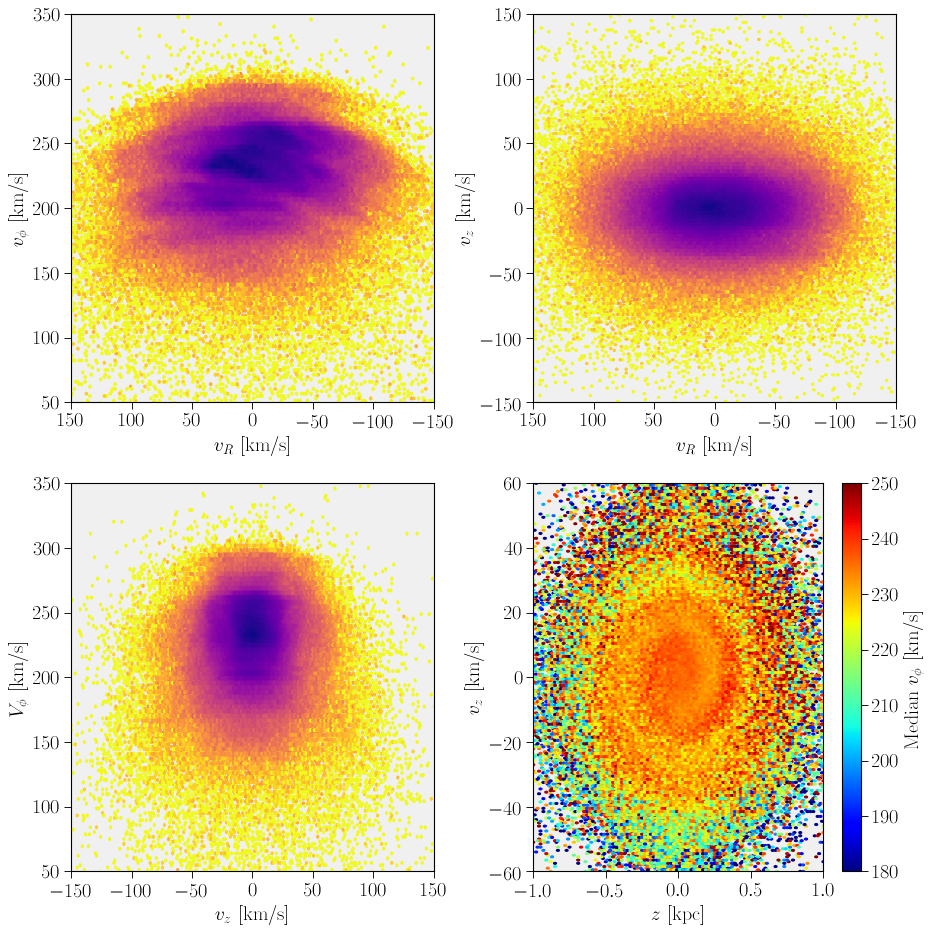

In [8]:
antoja = (R>=Rsun-100*u.pc) & (R<=Rsun+100*u.pc) & clean_poskin

print("Number of sources in selection: {0}".format(vR[antoja].size))

figUVW = plt.figure(figsize=(12,12))
axUV = figUVW.add_subplot(221)
axUW = figUVW.add_subplot(222)
axVW = figUVW.add_subplot(223)
axZW = figUVW.add_subplot(224)

axUV.hexbin(vR[antoja], vphi[antoja], mincnt=1, bins='log', gridsize=500, cmap='plasma_r')
axUV.set_xlabel(r'$v_R$ [km/s]')
axUV.set_ylabel(r'$v_\phi$ [km/s]')
axUV.set_xlim(-150,150)
axUV.set_ylim(50,350)
axUV.invert_xaxis()

axUW.hexbin(vR[antoja], vz[antoja], mincnt=1, bins='log', gridsize=500, cmap='plasma_r')
axUW.set_xlabel(r'$v_R$ [km/s]')
axUW.set_ylabel(r'$v_z$ [km/s]')
axUW.set_xlim(-150,150)
axUW.set_ylim(-150,150)
axUW.invert_xaxis()

axVW.hexbin(vz[antoja], vphi[antoja], mincnt=1, bins='log', gridsize=500, cmap='plasma_r')
axVW.set_ylabel(r'$V_\phi$ [km/s]')
axVW.set_xlabel(r'$v_z$ [km/s]')
axVW.set_ylim(50,350)
axVW.set_xlim(-150,150)

hbZW = axZW.hexbin(z[antoja]/1000, vz[antoja], mincnt=1, gridsize=(100,120), extent=[-1,1,-60,60], 
            cmap='jet', bins=None, C=vphi[antoja], reduce_C_function=np.median, vmin=180, vmax=250)
axZW.set_xlabel(r'$z$ [kpc]')
axZW.set_ylabel(r'$v_z$ [km/s]')
axZW.set_xlim(-1,1)
axZW.set_ylim(-60,60)
cbarZW = fig.colorbar(hbZW, ax=axZW)
cbarZW.set_label(r'Median $v_\phi$ [km/s]')

plt.tight_layout()
plt.show()

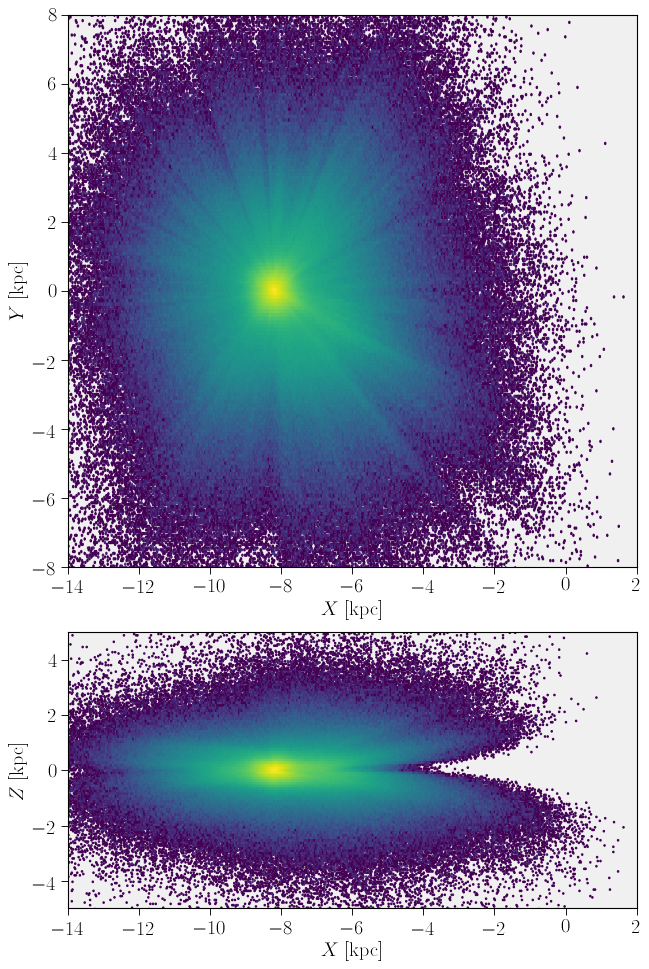

In [9]:
figxyz = plt.figure(figsize=(8,12), constrained_layout=True)
gs = GridSpec(3, 1, figure=figxyz)
axxy = figxyz.add_subplot(gs[0:2])
axxz = figxyz.add_subplot(gs[2])

axxy.hexbin(galactocentric_cartesian.x[clean_poskin]/1000, 
            galactocentric_cartesian.y[clean_poskin]/1000, mincnt=1, bins='log', gridsize=500, cmap='viridis')
axxy.set_xlim(-14,2)
axxy.set_ylim(-8,8)
axxy.set_xlabel('$X$ [kpc]')
axxy.set_ylabel('$Y$ [kpc]')

axxz.hexbin(galactocentric_cartesian.x[clean_poskin]/1000, 
            galactocentric_cartesian.z[clean_poskin]/1000, mincnt=1, bins='log', gridsize=500, cmap='viridis')
axxz.set_xlim(-14,2)
axxz.set_ylim(-5,5)
axxz.set_xlabel('$X$ [kpc]')
axxz.set_ylabel('$Z$ [kpc]')

plt.show()